# Transfer Learning
The objective in this notebook is to use **transfer learning** along with data augmentation pipelines from the previous
notebook to see if we can get a better performance and use that instead of our custom CNN. We'll use different backbones such as
- ResNet34
- DenseNet
- EfficientNet
- GoogLeNet
- VGG

In [64]:
import os
import pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.io import save_model

%matplotlib inline

In [2]:
BRISC_DATA_PATH = pathlib.Path('brisc2025')
CLASSIFICATION_PATH = BRISC_DATA_PATH / 'classification_task'
TRAIN_DATA_PATH = CLASSIFICATION_PATH / 'train'
TEST_DATA_PATH = CLASSIFICATION_PATH / 'test'

## Data Loading and Preprocessing

In [8]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [9]:
train_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.RandomCrop((224, 224)),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

test_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [10]:
to_tensor = lambda x: torch.tensor(x, dtype=torch.long)

In [11]:
generator = torch.Generator().manual_seed(42)

# Datasets using 80% - 20% for training and validation
dataset = ImageFolder(TRAIN_DATA_PATH, transform=train_pipeline, target_transform=to_tensor)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator)

# Test dataset for final evaluation
test_dataset = ImageFolder(TEST_DATA_PATH, transform=test_pipeline, target_transform=to_tensor)

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(4000, 1000, 1000)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Training using Transfer Learning
There are two types of transfer learning techniques: **Fine Tuning** and **Freezing** (using the pretrained model as a feature extractor).

For this tasks due to the size of our training dataset (5K images) we'll go to the second one, the first option is not feasible.

Since all the pretrained models in TorchVision where trained on **ImageNet** they expect 3 channel input images (RGB) and their output consist of 1000 classes. We need to adapt them to out data:
- 1 channel input images
- 4 output classes

In [18]:
from torch import nn, optim
from torchvision import models
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, F1Score, Recall, Precision

In [19]:
# Set up accelerator if hardware is available
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.mps.is_available() else
    'cpu'
)

print(f"Accelerator: {device}")

Accelerator: mps


In [20]:
# Set up metrics to evaluate model with
metrics = MetricCollection({
    'accuracy': Accuracy(task='multiclass', num_classes=4),
    'f1_score': F1Score(task='multiclass', num_classes=4, average='macro'),
    'recall': Recall(task='multiclass', num_classes=4, average='macro'),
    'precision': Precision(task='multiclass', num_classes=4, average='macro'),
}).to(device)

train_metrics = metrics.clone(prefix='train_')
val_metrics = metrics.clone(prefix='val_')
test_metrics = metrics.clone(prefix='test_')

In [22]:
def train_loop(model, dataloader, loss_fn, optimizer, metrics, *, device='cpu'):
    train_loss = 0
    num_batches = len(dataloader)

    model.train()
    metrics.reset()

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        pred = model(image) # Assuming our loss expects logits
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # Using not scheduler

        train_loss += loss.item() 
        metrics.update(pred, label)

    epoch_loss = train_loss / num_batches
    epoch_metrics = metrics.compute()

    print(f"Train Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_metrics['train_accuracy']:.4f}")

    return epoch_loss, epoch_metrics

In [23]:
def test_loop(model, dataloader, loss_fn, metrics, *, device='cpu', mode='test'):
    test_loss = 0
    num_batches = len(dataloader)

    model.eval()
    metrics.reset()
    
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            pred = model(image)
            test_loss += loss_fn(pred, label).item()
            metrics.update(pred, label)

    epoch_loss = test_loss / num_batches
    epoch_metrics = metrics.compute()
    
    if mode == 'val':
        print(f"Val Loss: {epoch_loss:.4f} - Val Accuracy: {epoch_metrics['val_accuracy']:.4f}")
        return epoch_loss, epoch_metrics

    return epoch_metrics

In [25]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

### EfficientNet B0

In [26]:
weights = models.EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)

In [27]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

model = model.to(device)

In [28]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.8')):
        param.requires_grad = False

In [31]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, t_metrics = train_loop(model, train_loader, loss_fn, optimizer, train_metrics, device=device)
    val_loss, v_metrics = test_loop(model, test_loader, loss_fn, val_metrics, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    for (t_metric, v_metric) in zip(t_metrics, v_metrics):
        history[t_metric].append(t_metrics[t_metric].item())
        history[v_metric].append(v_metrics[v_metric].item())

Epoch 1
---------------
Train Loss: 0.4592 - Train Accuracy: 0.8453
Val Loss: 0.3612 - Val Accuracy: 0.8510
Epoch 2
---------------
Train Loss: 0.2882 - Train Accuracy: 0.8910
Val Loss: 0.2488 - Val Accuracy: 0.9030
Epoch 3
---------------
Train Loss: 0.2298 - Train Accuracy: 0.9165
Val Loss: 0.2048 - Val Accuracy: 0.9210
Epoch 4
---------------
Train Loss: 0.1823 - Train Accuracy: 0.9362
Val Loss: 0.2023 - Val Accuracy: 0.9150
Epoch 5
---------------
Train Loss: 0.1552 - Train Accuracy: 0.9433
Val Loss: 0.2034 - Val Accuracy: 0.9060
Epoch 6
---------------
Train Loss: 0.1565 - Train Accuracy: 0.9417
Val Loss: 0.1811 - Val Accuracy: 0.9230
Epoch 7
---------------
Train Loss: 0.1478 - Train Accuracy: 0.9410
Val Loss: 0.1583 - Val Accuracy: 0.9290
Epoch 8
---------------
Train Loss: 0.1317 - Train Accuracy: 0.9540
Val Loss: 0.1683 - Val Accuracy: 0.9360
Epoch 9
---------------
Train Loss: 0.1152 - Train Accuracy: 0.9567
Val Loss: 0.1305 - Val Accuracy: 0.9510
Epoch 10
---------------
Tra

#### Model Evaluation

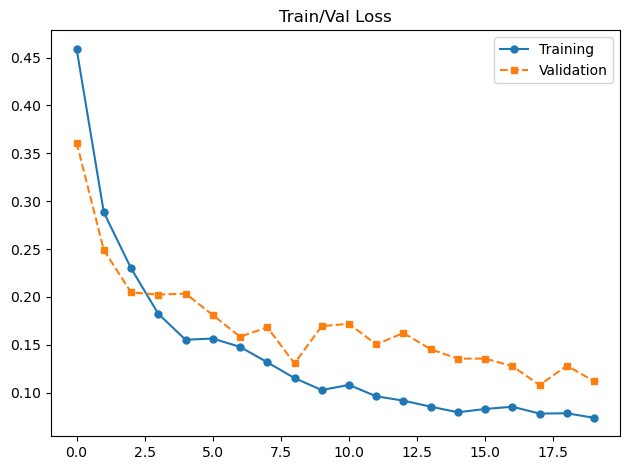

In [33]:
plt.plot(history['train_loss'], 'o-', markersize=5, label='Training')
plt.plot(history['val_loss'], 's--', markersize=5, label='Validation')
plt.title('Train/Val Loss')
plt.legend()

plt.tight_layout()
plt.show()

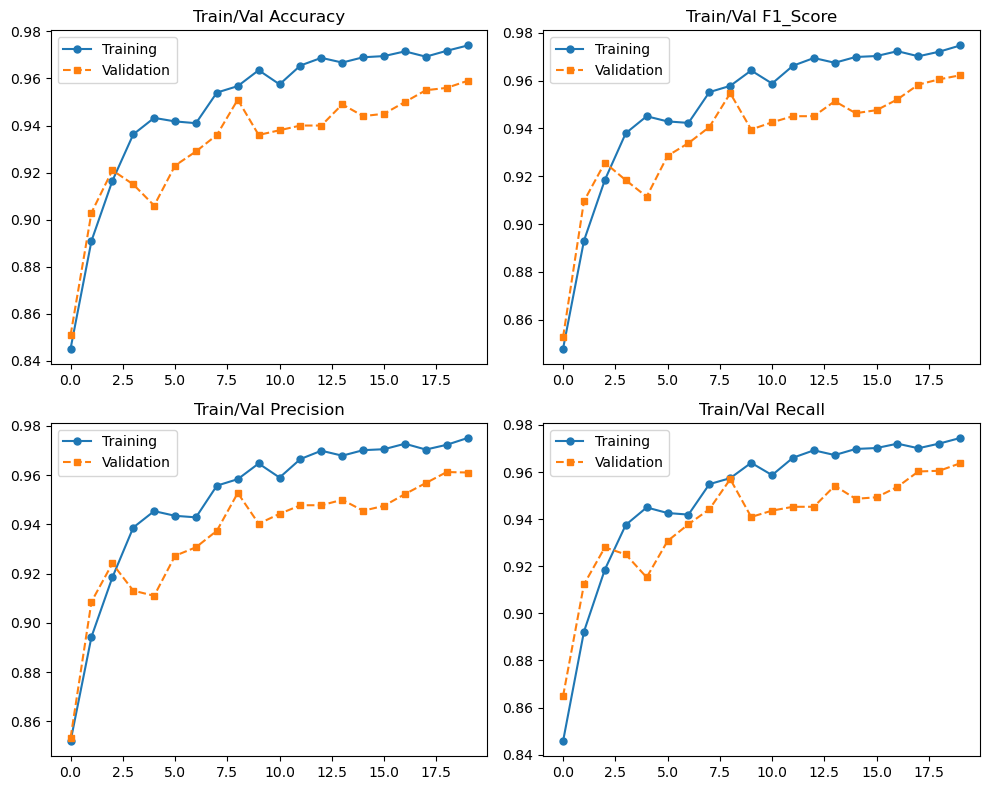

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, metric in enumerate(metrics.keys()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.plot(history[f'train_{metric}'], 'o-', markersize=5, label='Training')
    ax.plot(history[f'val_{metric}'], 's--', markersize=5, label='Validation')
    ax.set_title(f'Train/Val {metric.title()}')
    ax.legend()
plt.tight_layout()
plt.show()

In [35]:
final_metrics = test_loop(model, test_loader, loss_fn, test_metrics, device=device)

In [36]:
for metric, value in final_metrics.items():
    _, name = metric.split('_', 1)
    print(f'{name.title()}: {value.item():4f}')

Accuracy: 0.959000
F1_Score: 0.962280
Precision: 0.961038
Recall: 0.963713


In [37]:
model_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'This model has: {model_params} params')

This model has: 417284 params


In [38]:
# Save model if it the best

### ResNet

In [54]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

In [55]:
old_conv = model.conv1

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.conv1 = new_conv

model.fc = nn.Linear(in_features=512, out_features=4, bias=True)

model = model.to(device)

In [56]:
for name, param in model.named_parameters():
    if not name.startswith(('fc', 'layer4.2')):
        param.requires_grad = False

In [57]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, t_metrics = train_loop(model, train_loader, loss_fn, optimizer, train_metrics, device=device)
    val_loss, v_metrics = test_loop(model, test_loader, loss_fn, val_metrics, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    for (t_metric, v_metric) in zip(t_metrics, v_metrics):
        history[t_metric].append(t_metrics[t_metric].item())
        history[v_metric].append(v_metrics[v_metric].item())

Epoch 1
---------------
Train Loss: 0.3777 - Train Accuracy: 0.8668
Val Loss: 0.2683 - Val Accuracy: 0.8930
Epoch 2
---------------
Train Loss: 0.2266 - Train Accuracy: 0.9170
Val Loss: 0.2338 - Val Accuracy: 0.9210
Epoch 3
---------------
Train Loss: 0.1788 - Train Accuracy: 0.9350
Val Loss: 0.2431 - Val Accuracy: 0.9190
Epoch 4
---------------
Train Loss: 0.1736 - Train Accuracy: 0.9355
Val Loss: 0.1841 - Val Accuracy: 0.9340
Epoch 5
---------------
Train Loss: 0.1450 - Train Accuracy: 0.9448
Val Loss: 0.1702 - Val Accuracy: 0.9440
Epoch 6
---------------
Train Loss: 0.1399 - Train Accuracy: 0.9450
Val Loss: 0.1612 - Val Accuracy: 0.9420
Epoch 7
---------------
Train Loss: 0.1054 - Train Accuracy: 0.9638
Val Loss: 0.1513 - Val Accuracy: 0.9520
Epoch 8
---------------
Train Loss: 0.1033 - Train Accuracy: 0.9610
Val Loss: 0.1605 - Val Accuracy: 0.9440
Epoch 9
---------------
Train Loss: 0.0992 - Train Accuracy: 0.9617
Val Loss: 0.2259 - Val Accuracy: 0.9240
Epoch 10
---------------
Tra

#### Model Evaluation

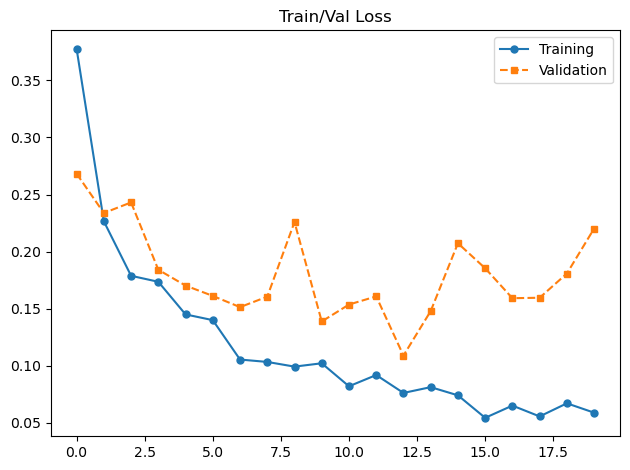

In [59]:
plt.plot(history['train_loss'], 'o-', markersize=5, label='Training')
plt.plot(history['val_loss'], 's--', markersize=5, label='Validation')
plt.title('Train/Val Loss')
plt.legend()

plt.tight_layout()
plt.show()

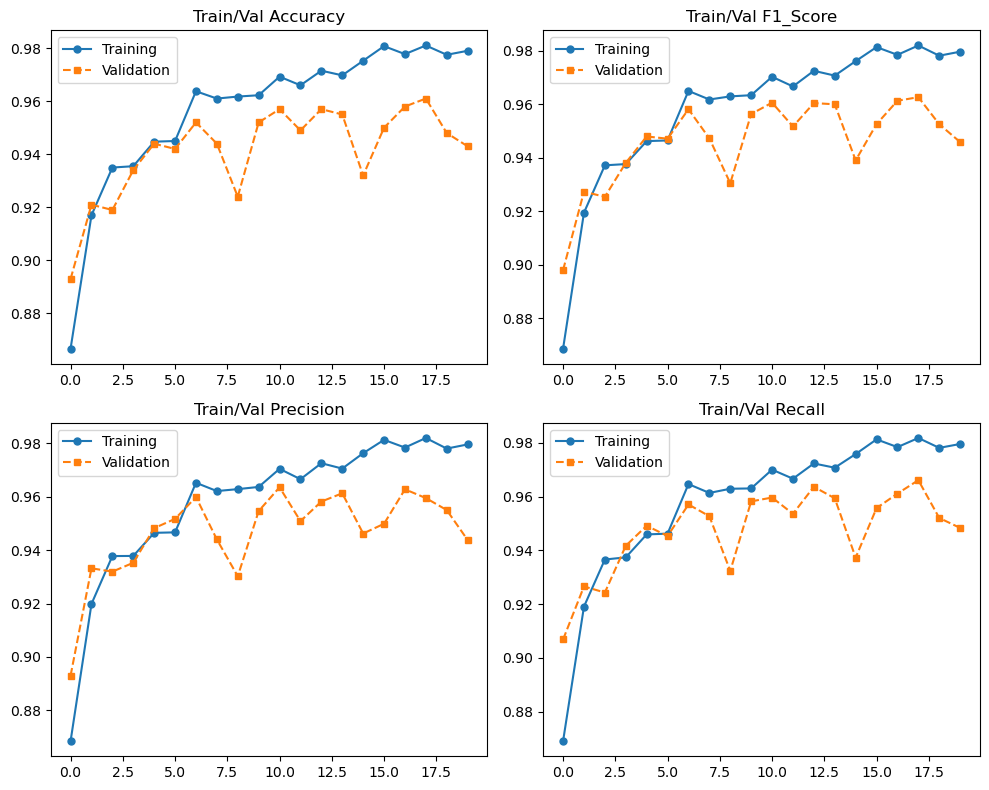

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, metric in enumerate(metrics.keys()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.plot(history[f'train_{metric}'], 'o-', markersize=5, label='Training')
    ax.plot(history[f'val_{metric}'], 's--', markersize=5, label='Validation')
    ax.set_title(f'Train/Val {metric.title()}')
    ax.legend()
plt.tight_layout()
plt.show()

In [61]:
final_metrics = test_loop(model, test_loader, loss_fn, test_metrics, device=device)

In [62]:
for metric, value in final_metrics.items():
    _, name = metric.split('_', 1)
    print(f'{name.title()}: {value.item():4f}')

Accuracy: 0.943000
F1_Score: 0.945795
Precision: 0.943803
Recall: 0.948318


In [63]:
model_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'This model has: {model_params} params')

This model has: 4722692 params


In [65]:
save_model(model, 'resnet34-backbone.pth')

### DenseNet

In [84]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

In [85]:
old_conv = model.features.conv0

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features.conv0 = new_conv
model.classifier = nn.Linear(in_features=1024, out_features=4, bias=True)

model = model.to(device)

In [87]:
for param in model.features.parameters():
    param.requires_grad = False

In [88]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

4100

In [89]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [90]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, t_metrics = train_loop(model, train_loader, loss_fn, optimizer, train_metrics, device=device)
    val_loss, v_metrics = test_loop(model, test_loader, loss_fn, val_metrics, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    for (t_metric, v_metric) in zip(t_metrics, v_metrics):
        history[t_metric].append(t_metrics[t_metric].item())
        history[v_metric].append(v_metrics[v_metric].item())

Epoch 1
---------------
Train Loss: 0.8107 - Train Accuracy: 0.7110
Val Loss: 0.5952 - Val Accuracy: 0.7750
Epoch 2
---------------
Train Loss: 0.4917 - Train Accuracy: 0.8347
Val Loss: 0.5333 - Val Accuracy: 0.7940
Epoch 3
---------------
Train Loss: 0.4013 - Train Accuracy: 0.8622
Val Loss: 0.5136 - Val Accuracy: 0.7920
Epoch 4
---------------
Train Loss: 0.3716 - Train Accuracy: 0.8725
Val Loss: 0.4300 - Val Accuracy: 0.8230
Epoch 5
---------------
Train Loss: 0.3449 - Train Accuracy: 0.8750
Val Loss: 0.4222 - Val Accuracy: 0.8270
Epoch 6
---------------
Train Loss: 0.3354 - Train Accuracy: 0.8792
Val Loss: 0.4350 - Val Accuracy: 0.8250
Epoch 7
---------------
Train Loss: 0.3277 - Train Accuracy: 0.8817
Val Loss: 0.4292 - Val Accuracy: 0.8240
Epoch 8
---------------
Train Loss: 0.3103 - Train Accuracy: 0.8860
Val Loss: 0.3902 - Val Accuracy: 0.8410
Epoch 9
---------------
Train Loss: 0.2917 - Train Accuracy: 0.8935
Val Loss: 0.4023 - Val Accuracy: 0.8390
Epoch 10
---------------
Tra

#### Model Evaluation

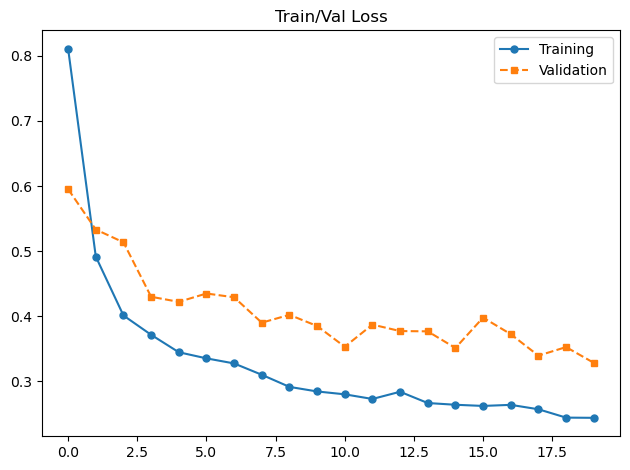

In [91]:
plt.plot(history['train_loss'], 'o-', markersize=5, label='Training')
plt.plot(history['val_loss'], 's--', markersize=5, label='Validation')
plt.title('Train/Val Loss')
plt.legend()

plt.tight_layout()
plt.show()

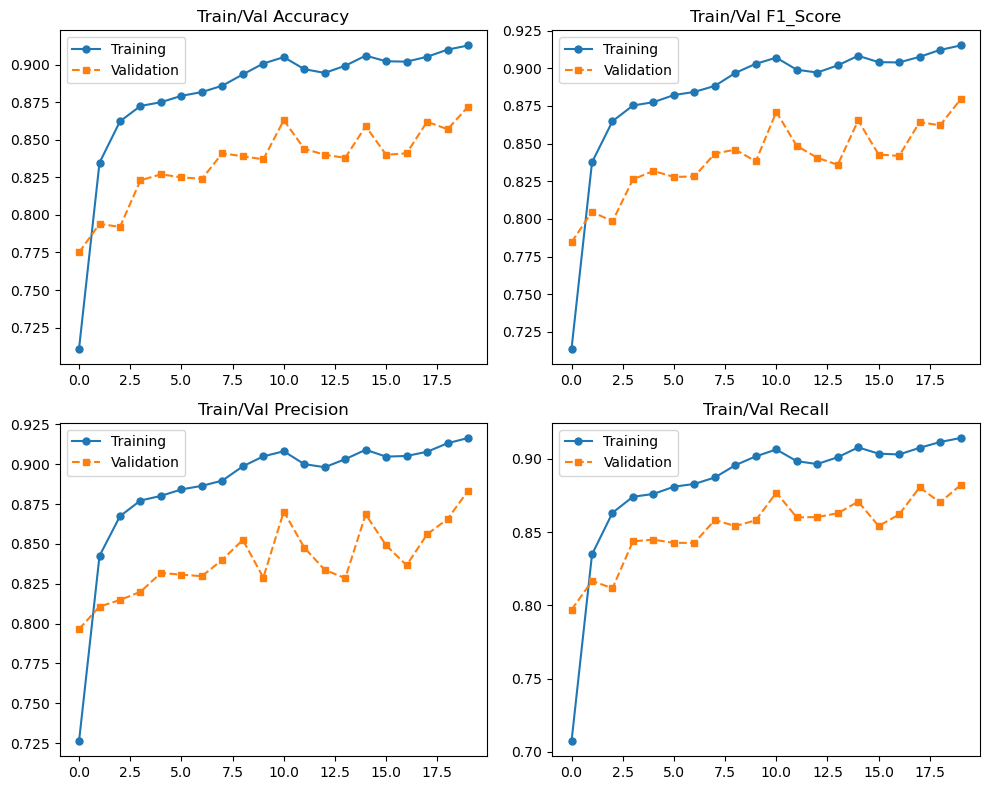

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, metric in enumerate(metrics.keys()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.plot(history[f'train_{metric}'], 'o-', markersize=5, label='Training')
    ax.plot(history[f'val_{metric}'], 's--', markersize=5, label='Validation')
    ax.set_title(f'Train/Val {metric.title()}')
    ax.legend()
plt.tight_layout()
plt.show()

In [93]:
final_metrics = test_loop(model, test_loader, loss_fn, test_metrics, device=device)

In [94]:
for metric, value in final_metrics.items():
    _, name = metric.split('_', 1)
    print(f'{name.title()}: {value.item():4f}')

Accuracy: 0.872000
F1_Score: 0.879369
Precision: 0.883294
Recall: 0.882120


In [95]:
model_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'This model has: {model_params} params')

This model has: 4100 params


In [96]:
save_model(model, 'densenet-backbone.pth')

### MobileNet

In [66]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [67]:
old_conv = model.features[0][0]

new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)

new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

model.features[0][0] = new_conv

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)

model = model.to(device)

In [68]:
# Freeze layers
for name, param in model.named_parameters():
    if not name.startswith(('classifier', 'features.8')):
        param.requires_grad = False

In [69]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

59396

In [70]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [71]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, t_metrics = train_loop(model, train_loader, loss_fn, optimizer, train_metrics, device=device)
    val_loss, v_metrics = test_loop(model, test_loader, loss_fn, val_metrics, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    for (t_metric, v_metric) in zip(t_metrics, v_metrics):
        history[t_metric].append(t_metrics[t_metric].item())
        history[v_metric].append(v_metrics[v_metric].item())

Epoch 1
---------------
Train Loss: 0.6566 - Train Accuracy: 0.7983
Val Loss: 0.4673 - Val Accuracy: 0.8020
Epoch 2
---------------
Train Loss: 0.3154 - Train Accuracy: 0.8953
Val Loss: 0.3601 - Val Accuracy: 0.8470
Epoch 3
---------------
Train Loss: 0.2558 - Train Accuracy: 0.9115
Val Loss: 0.2812 - Val Accuracy: 0.8910
Epoch 4
---------------
Train Loss: 0.2118 - Train Accuracy: 0.9247
Val Loss: 0.2482 - Val Accuracy: 0.9040
Epoch 5
---------------
Train Loss: 0.1629 - Train Accuracy: 0.9445
Val Loss: 0.1948 - Val Accuracy: 0.9270
Epoch 6
---------------
Train Loss: 0.1534 - Train Accuracy: 0.9463
Val Loss: 0.1864 - Val Accuracy: 0.9220
Epoch 7
---------------
Train Loss: 0.1319 - Train Accuracy: 0.9567
Val Loss: 0.1625 - Val Accuracy: 0.9370
Epoch 8
---------------
Train Loss: 0.1251 - Train Accuracy: 0.9555
Val Loss: 0.1591 - Val Accuracy: 0.9330
Epoch 9
---------------
Train Loss: 0.1081 - Train Accuracy: 0.9628
Val Loss: 0.1503 - Val Accuracy: 0.9500
Epoch 10
---------------
Tra

#### Model Evaluation

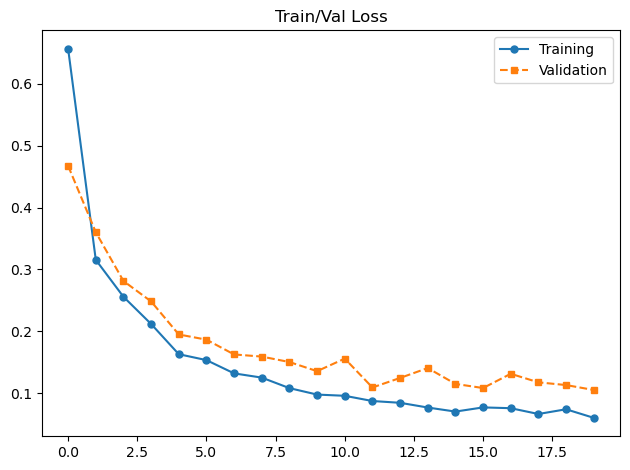

In [72]:
plt.plot(history['train_loss'], 'o-', markersize=5, label='Training')
plt.plot(history['val_loss'], 's--', markersize=5, label='Validation')
plt.title('Train/Val Loss')
plt.legend()

plt.tight_layout()
plt.show()

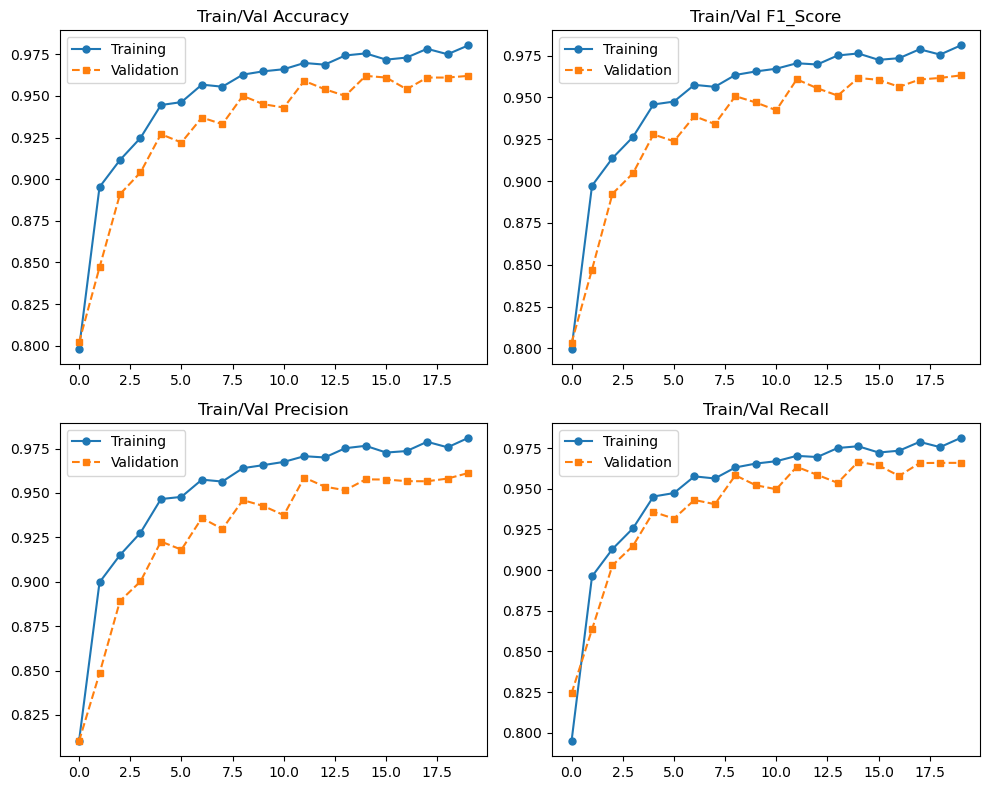

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, metric in enumerate(metrics.keys()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.plot(history[f'train_{metric}'], 'o-', markersize=5, label='Training')
    ax.plot(history[f'val_{metric}'], 's--', markersize=5, label='Validation')
    ax.set_title(f'Train/Val {metric.title()}')
    ax.legend()
plt.tight_layout()
plt.show()

In [74]:
final_metrics = test_loop(model, test_loader, loss_fn, test_metrics, device=device)

In [75]:
for metric, value in final_metrics.items():
    _, name = metric.split('_', 1)
    print(f'{name.title()}: {value.item():4f}')

Accuracy: 0.962000
F1_Score: 0.963146
Precision: 0.961163
Recall: 0.965878


In [76]:
model_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'This model has: {model_params} params')

This model has: 59396 params


In [77]:
save_model(model, 'mobilenet-backbone.pth')